In [5]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [6]:

def imshow(image):
    if len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[-1] == 1):
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

Projekt do rozpoznawania automatycznego numerów kart kredytowych z obrazu. Cyfry będziemy dopasowywać do wzorców i porównywać do której cyfry znalezionej jest najbliżej.

# 1. Przetwarzanie wzorców cyfr

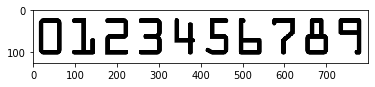

In [7]:
font_path = 'agh_cv/credit_cards/images/ocr_a.png'
font_image = cv2.imread(font_path)
imshow(font_image)

Musimy w jakiś sposób podzielić ten obraz na cyfry. Wykorzystamy do tego funkcję __findContours__. Jednakże działa ona poprawnie dla białych kształtów na czarnym tle. Dlatego sprowadźmy po pierwsze obraz do skali szarości a następnie wykorzystajmy poznaną już metodę progowania binarnego odwróconego w celu pozostawienia pikseli tylko o wartościach 0 lub 255.

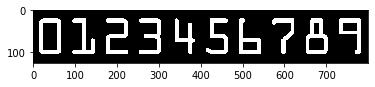

In [10]:
gray_font_image = cv2.cvtColor(font_image, cv2.COLOR_BGR2GRAY)
binary_font_image = cv2.threshold(gray_font_image, 10, 255, cv2.THRESH_BINARY_INV)[1]
imshow(binary_font_image)

Drugi parametr cv2.RETR_TREE mówi OpenCV, aby obliczył hierarchię (relację) między konturami. Mogliśmy również użyć opcji cv2.RETR_LIST. Na koniec mówimy OpenCV, aby skompresowało kontury, aby zaoszczędzić miejsce za pomocą cv2.CV_CHAIN_APPROX_SIMPLE.

In [11]:
contours = cv2.findContours(binary_font_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [12]:
# W zależności od wersji opencv, różnice w v2.4, v3.0, v4-alpha, v4-beta
if len(contours) == 2:
    contours = contours[0]
elif len(contours) == 3:
    contours = contours[1]

In [13]:
print(len(contours))

10


Znaleziono 10 konturów, dokładnie tyle ile jest cyfr na naszym obrazie. Należy je teraz posostować od lewej do prawej. Kontur to dosłownie zbiór pikseli tworzące obramowanie. Za pomocą funkcji __boundingRect__ możemy uzyskać reprezentację za pomocą czterech liczb przedstawiające lewy górny róg każdej ramki a także jej szerokość i wysokość.

In [14]:
bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
bounding_boxes = sorted(bounding_boxes, key=lambda box: box[0])

max_width = max([box[2] for box in bounding_boxes])
max_height = max([box[3] for box in bounding_boxes])

Wyodrębnijmy teraz każdą cyfrę z obrazu, zapiszmy ją do słownika pod odpowiednim kluczem, a także zmieńmy rozmiar wszystkich wyciętych cyfr do takiego samego wymiaru.

In [15]:
digits = {}

for (index, box) in enumerate(bounding_boxes):
    (x, y, w, h) = box
    roi = binary_font_image[y:y + h, x:x + w]
    roi = cv2.resize(roi, (max_width, max_height))

    digits[index] = roi

print(len(digits))

10


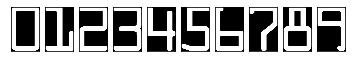

In [19]:
fig = plt.figure()

for i in range(1, 11):
    plt.subplot(1, 10, i)
    plt.xticks([]), plt.yticks([])
    imshow(digits[i - 1])

plt.show()


# 2. Przetwarzanie zdjęcia karty
Będziemy skalować obrazy do szerokości 300px

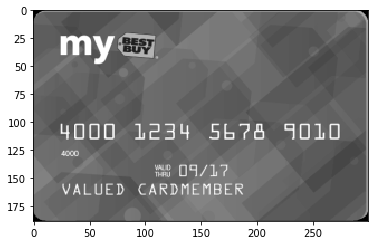

In [25]:
card_image_path = 'agh_cv/credit_cards/images/credit_card_01.png'
card_image = cv2.imread(card_image_path)
card_image = cv2.cvtColor(card_image, cv2.COLOR_BGR2RGB)
card_image = cv2.resize(card_image, (300, int(card_image.shape[0] * (300 / card_image.shape[1]))),
                        interpolation = cv2.INTER_AREA)

gray_card_image = cv2.cvtColor(card_image, cv2.COLOR_BGR2GRAY)

height, width = gray_card_image.shape
imshow(gray_card_image)

Stosujemy transformację morfologiczną Otwartą filtrem prostokątnym w celu wyróżnienia cyfr oraz usunięcia drobnych szumów. Następnie wykonujemy różnicę pomiędzy szarym obrazem oryginalnym a wynikem transformacji morfologicznej.

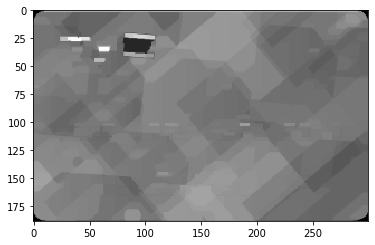

In [26]:
rectangle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
open_morphology = cv2.morphologyEx(gray_card_image, cv2.MORPH_OPEN, rectangle_kernel)
imshow(open_morphology)

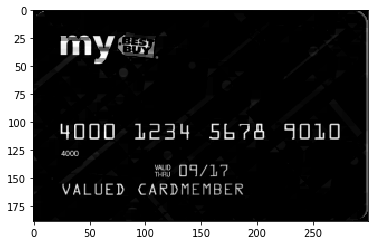

In [27]:
result = gray_card_image - open_morphology
imshow(result)

Wyznaczamy następnie krawędzie na obrazie wykorzystując operator Sobela. Po uzyskaniu wyniku musimy przeskalować uzyskany obraz do wartości pikseli z zakresu [0, 255]

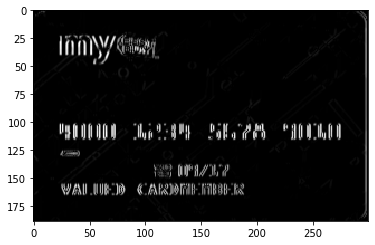

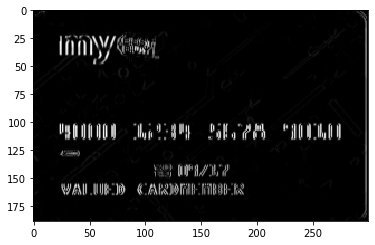

In [32]:
grad_x = cv2.Sobel(result, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=-1)
grad_x = np.absolute(grad_x)
imshow(grad_x)
plt.show()
(min_val, max_val) = (np.min(grad_x), np.max(grad_x))
grad_x = (255 * ((grad_x - min_val) / (max_val - min_val)))
grad_x = grad_x.astype("uint8")
imshow(grad_x)


Zastosujmy teraz transformację morfologiczną zamknięcia w celu wypełnienia luk pomiędzy cyframi karty kredytowej, a następnie metodę progowania w celu binaryzacji obrazu.

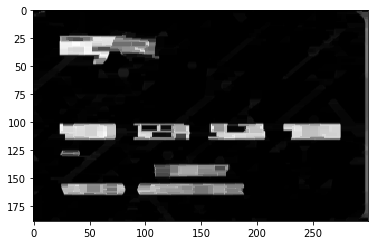

In [33]:
closed_grad_x = cv2.morphologyEx(grad_x, cv2.MORPH_CLOSE, rectangle_kernel)
imshow(closed_grad_x)

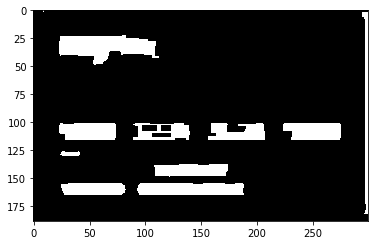

In [34]:
# card_threshold = cv2.adaptiveThreshold(closed_grad_x, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 9)
ret, card_threshold = cv2.threshold(closed_grad_x, 60, 255, cv2.THRESH_BINARY)
imshow(card_threshold)

Ponownie zastosujmy operację transformacji morfologicznej zamknięcia w celu zamknięcia luk między cyframi. tym razem filtrem kwadratowym.

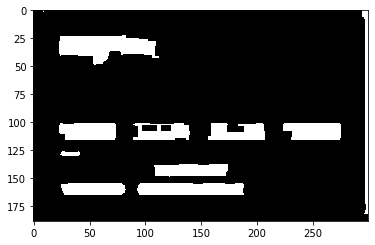

In [35]:
square_filter = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
closed_threshold = cv2.morphologyEx(card_threshold, cv2.MORPH_CLOSE, square_filter)
imshow(closed_threshold)

Ponownie wykorzystajmy funkcję do znajdowania konturów

In [42]:
contours = cv2.findContours(closed_threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if len(contours) == 2:
    contours = contours[0]
elif len(contours) == 3:
    contours = contours[1]
    
print(len(contours))

11


Ze znalezionych konturów musimy ponownie utworzyć bounding boxy. A następnie obliczymy dla każdego z nich aspect ratio czyli podzielimy jego szerokość przez długość.

Ponieważ karty kredytowe używają czcionek o stałym rozmiarze z 4 grupami 4 cyfr, możemy przyciąć potencjalne kontury w oparciu o współczynnik kształtu obrazu.

In [43]:
good_boxes = []
for (index, contour) in enumerate(contours):
    (x, y, w, h) = cv2.boundingRect(contour)
    aspect_ratio = w / float(h)    

    if aspect_ratio > 2.5 and aspect_ratio < 4.0:
        if (w > 40 and w < 55) and (h > 10 and h < 20):
            good_boxes.append((x, y, w, h))
print(len(good_boxes))

4


Posortujmy ramki od lewej do prawej. Następnie wybieramy z oryginalnego obrazu kolejne bloki czterech cyfr i je przetwarzamy i dzielimy grupy na cyfry ponownie wykorzystując funkcję __findContours__.

In [44]:
good_boxes = sorted(good_boxes, key=lambda box: box[0])

Credit Card #: 4000123456789010


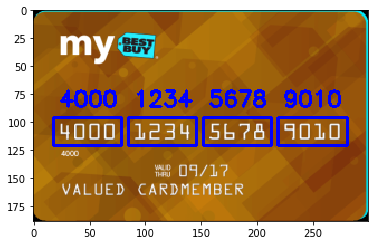

In [50]:
card_number = []
# Dla każdej znalezionej grupy cyfr
for (i, (gX, gY, gW, gH)) in enumerate(good_boxes):
    group_result = []
    
    
    # Wybierz grupę z szarego obrazu z paddingiem 5px z każdej strony i wykonaj binarny thresholding
    group = gray_card_image[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
    ret, group_threshold = cv2.threshold(group, 127, 255, cv2.THRESH_BINARY)
    
    # Znajdź kontury cyfr
    digit_contours = cv2.findContours(group_threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(digit_contours) == 2:
        digit_contours = digit_contours[0]
    elif len(digit_contours) == 3:
        digit_contours = digit_contours[1]
    
    # Utwórz boxy z konturów i posortuj je
    digit_boxes = [cv2.boundingRect(contour) for contour in digit_contours]
    digit_boxes = sorted(digit_boxes, key=lambda box: box[0])
    
    # Dla każdego boxa cyfry wyciągnij cyfrę jako region of interest i zrób resize do (57, 88)
    for box in digit_boxes:
        (x, y, w, h) = box
        roi = group_threshold[y:y + h, x:x + w]
        roi = cv2.resize(roi, (57, 88))

        # zainicjuj listę wyników pasujących do szablonu
        scores = []

        for (digit, digitROI) in digits.items():
            # zastosuj dopasowanie szablonu oparte na korelacji, weź
            # wynik i zaktualizuj listę wyników
            result = cv2.matchTemplate(roi, digitROI, cv2.TM_CCOEFF) #Porównuje szablon z nakładającymi się regionami obrazu.
            (_, score, _, _) = cv2.minMaxLoc(result) #Znajduje globalne minimum i maksimum w tablicy.
            scores.append(score)

        # klasyfikacja cyfrowa ROI będzie nazwą cyfry referencyjnej z największym wynikiem dopasowania szablonu
        group_result.append(str(np.argmax(scores)))

    # narysuj klasyfikacje cyfrowe wokół grupy
    cv2.rectangle(card_image, (gX - 5, gY - 5), (gX + gW + 5, gY + gH + 5), (255, 0, 0), 2)
    cv2.putText(card_image, "".join(group_result), (gX, gY - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 0, 0), 2)

    card_number.extend(group_result)
    
imshow(card_image)
print("Credit Card #: {}".format("".join(card_number)))

## Zadanie
Przeanalizuj kod ponownie a następnie zdefiniuj funkcję, która przyjmie ścieżkę do pliku a wynik jej działania jest taki sam jak całego powyższego kodu: Wydrukowanie typu karty, jej numeru oraz obrazu z naniesionymi ramkami i numerem karty. Możesz definiować funkcje pomocnicze do kolejnych kroków i uporządkować kod.

Dostarczyliśmy inne zdjęcia kart o takich ścieżkach do przetestowania
- 'images/credit_card_01.png'
- 'images/credit_card_02.png'
- 'images/credit_card_03.png'
- 'images/credit_card_04.png'
- 'images/credit_card_05.png'

